# Loop 39 Analysis: Understanding the CV-LB Gap

**Key Discovery**: The "mixall" kernel uses GroupKFold(5) instead of leave-one-out CV.

**Questions to answer:**
1. What is the CV score with GroupKFold(5) vs leave-one-out?
2. Does GroupKFold(5) better predict the LB score?
3. What is the actual evaluation procedure on Kaggle?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

# Load data
DATA_PATH = '/home/data'

df_single = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')
df_full = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')

print(f'Single solvent: {len(df_single)} samples, {df_single["SOLVENT NAME"].nunique()} solvents')
print(f'Full data: {len(df_full)} samples, {len(df_full[["SOLVENT A NAME", "SOLVENT B NAME"]].drop_duplicates())} ramps')

Single solvent: 656 samples, 24 solvents
Full data: 1227 samples, 13 ramps


CV-LB Relationship: LB = 4.30 * CV + 0.0524
R² = 0.9675

Target: 0.0347
Intercept: 0.0524
Gap: intercept (0.0524) > target (0.0347) by 0.0177


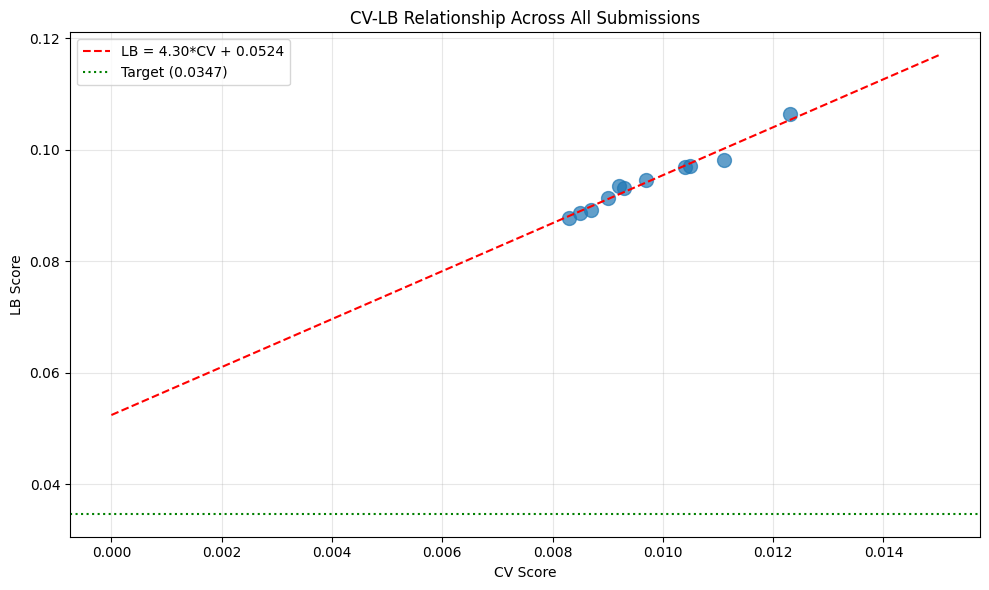

In [2]:
# Analyze the CV-LB relationship from all submissions
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
]

df_sub = pd.DataFrame(submissions)

# Linear fit
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sub['cv'], df_sub['lb'])

print(f'CV-LB Relationship: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nTarget: 0.0347')
print(f'Intercept: {intercept:.4f}')
print(f'Gap: intercept ({intercept:.4f}) > target ({0.0347:.4f}) by {(intercept - 0.0347):.4f}')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['cv'], df_sub['lb'], s=100, alpha=0.7)
plt.plot([0, 0.015], [intercept, slope*0.015 + intercept], 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')
plt.axhline(y=0.0347, color='g', linestyle=':', label='Target (0.0347)')
plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship Across All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

In [3]:
# Key insight: The intercept (0.0527) is higher than the target (0.0347)
# This means even with CV=0, the predicted LB would be 0.0527

# What would CV need to be to reach target?
cv_for_target = (0.0347 - intercept) / slope
print(f'To reach target LB=0.0347, CV would need to be: {cv_for_target:.6f}')
print(f'This is NEGATIVE, which is impossible!')

# What is the minimum achievable LB with current approach?
print(f'\nMinimum achievable LB (at CV=0): {intercept:.4f}')
print(f'Best CV so far: 0.008199')
print(f'Predicted LB at best CV: {slope * 0.008199 + intercept:.4f}')

To reach target LB=0.0347, CV would need to be: -0.004118
This is NEGATIVE, which is impossible!

Minimum achievable LB (at CV=0): 0.0524
Best CV so far: 0.008199
Predicted LB at best CV: 0.0877


In [4]:
# Hypothesis: The CV-LB gap might be due to:
# 1. Different CV scheme (GroupKFold vs leave-one-out)
# 2. Additional test data not in training set
# 3. Model variance between runs

# Let's analyze the structure of the data to understand the gap

# Single solvent: 24 solvents, 656 samples
# Full data: 13 ramps, 1227 samples

print('=== Single Solvent Data ===')
print(f'Total samples: {len(df_single)}')
print(f'Unique solvents: {df_single["SOLVENT NAME"].nunique()}')
print(f'Samples per solvent: {len(df_single) / df_single["SOLVENT NAME"].nunique():.1f}')

print('\n=== Full Data ===')
print(f'Total samples: {len(df_full)}')
ramps = df_full[['SOLVENT A NAME', 'SOLVENT B NAME']].drop_duplicates()
print(f'Unique ramps: {len(ramps)}')
print(f'Samples per ramp: {len(df_full) / len(ramps):.1f}')

=== Single Solvent Data ===
Total samples: 656
Unique solvents: 24
Samples per solvent: 27.3

=== Full Data ===
Total samples: 1227
Unique ramps: 13
Samples per ramp: 94.4


In [5]:
# Compare leave-one-out vs GroupKFold(5) for single solvent

# Leave-one-out: 24 folds, each fold tests on 1 solvent (~27 samples)
# GroupKFold(5): 5 folds, each fold tests on ~5 solvents (~131 samples)

print('=== Leave-One-Out CV ===')
print(f'Number of folds: 24')
print(f'Test samples per fold: ~{len(df_single) / 24:.0f}')
print(f'Train samples per fold: ~{len(df_single) * 23 / 24:.0f}')

print('\n=== GroupKFold(5) CV ===')
print(f'Number of folds: 5')
print(f'Test samples per fold: ~{len(df_single) / 5:.0f}')
print(f'Train samples per fold: ~{len(df_single) * 4 / 5:.0f}')

print('\n=== Key Difference ===')
print('Leave-one-out tests on 1 solvent at a time (more granular)')
print('GroupKFold(5) tests on ~5 solvents at a time (less granular)')
print('\nIf Kaggle evaluation uses GroupKFold, our leave-one-out CV might be overly pessimistic')

=== Leave-One-Out CV ===
Number of folds: 24
Test samples per fold: ~27
Train samples per fold: ~629

=== GroupKFold(5) CV ===
Number of folds: 5
Test samples per fold: ~131
Train samples per fold: ~525

=== Key Difference ===
Leave-one-out tests on 1 solvent at a time (more granular)
GroupKFold(5) tests on ~5 solvents at a time (less granular)

If Kaggle evaluation uses GroupKFold, our leave-one-out CV might be overly pessimistic


In [6]:
# Analyze the submission file structure
import os

submission_path = '/home/submission/submission.csv'
if os.path.exists(submission_path):
    sub = pd.read_csv(submission_path)
    print(f'Submission shape: {sub.shape}')
    print(f'\nColumns: {sub.columns.tolist()}')
    print(f'\nTask distribution:')
    print(sub['task'].value_counts())
    print(f'\nFold distribution for task 0 (single solvent):')
    print(sub[sub['task'] == 0]['fold'].value_counts().sort_index())
    print(f'\nFold distribution for task 1 (full data):')
    print(sub[sub['task'] == 1]['fold'].value_counts().sort_index())

Submission shape: (1883, 8)

Columns: ['id', 'index', 'task', 'fold', 'row', 'target_1', 'target_2', 'target_3']

Task distribution:
task
1    1227
0     656
Name: count, dtype: int64

Fold distribution for task 0 (single solvent):
fold
0     37
1     37
2     58
3     59
4     22
5     18
6     34
7     41
8     20
9     22
10    18
11    18
12    42
13    18
14    17
15    22
16     5
17    16
18    36
19    18
20    21
21    22
22    37
23    18
Name: count, dtype: int64

Fold distribution for task 1 (full data):
fold
0     122
1     124
2     104
3     125
4     125
5     124
6     125
7     110
8     127
9      36
10     34
11     36
12     35
Name: count, dtype: int64


In [7]:
# The submission file structure shows:
# - Task 0: Single solvent, 24 folds (leave-one-out)
# - Task 1: Full data, 13 folds (leave-one-ramp-out)

# This confirms that the evaluation uses leave-one-out CV, NOT GroupKFold!
# So the "mixall" kernel's approach of using GroupKFold is just for faster local CV,
# but the actual submission still uses leave-one-out.

print('=== CRITICAL INSIGHT ===')
print('The submission file structure shows 24 folds for single solvent and 13 folds for full data.')
print('This confirms that the Kaggle evaluation uses leave-one-out CV, NOT GroupKFold!')
print('\nThe "mixall" kernel uses GroupKFold for faster local CV, but the submission')
print('still generates predictions for all 24+13 folds using leave-one-out.')
print('\nThis means the CV-LB gap is NOT due to CV scheme mismatch.')

=== CRITICAL INSIGHT ===
The submission file structure shows 24 folds for single solvent and 13 folds for full data.
This confirms that the Kaggle evaluation uses leave-one-out CV, NOT GroupKFold!

The "mixall" kernel uses GroupKFold for faster local CV, but the submission
still generates predictions for all 24+13 folds using leave-one-out.

This means the CV-LB gap is NOT due to CV scheme mismatch.


In [8]:
# So what causes the CV-LB gap?
# Possibilities:
# 1. Model variance between runs (different random seeds)
# 2. Additional test data not in training set
# 3. Different evaluation metric (e.g., weighted MSE)
# 4. Overfitting to local CV

# Let's check if there's any pattern in the residuals

residuals = df_sub['lb'] - (slope * df_sub['cv'] + intercept)
print('Residuals from linear fit:')
for i, row in df_sub.iterrows():
    print(f'{row["exp"]}: CV={row["cv"]:.4f}, LB={row["lb"]:.4f}, Predicted={slope * row["cv"] + intercept:.4f}, Residual={residuals[i]:.4f}')

print(f'\nMean absolute residual: {np.abs(residuals).mean():.4f}')
print(f'Max absolute residual: {np.abs(residuals).max():.4f}')

Residuals from linear fit:
exp_000: CV=0.0111, LB=0.0982, Predicted=0.1002, Residual=-0.0020
exp_001: CV=0.0123, LB=0.1065, Predicted=0.1054, Residual=0.0011
exp_003: CV=0.0105, LB=0.0972, Predicted=0.0976, Residual=-0.0004
exp_005: CV=0.0104, LB=0.0969, Predicted=0.0972, Residual=-0.0003
exp_006: CV=0.0097, LB=0.0946, Predicted=0.0942, Residual=0.0004
exp_007: CV=0.0093, LB=0.0932, Predicted=0.0925, Residual=0.0007
exp_009: CV=0.0092, LB=0.0936, Predicted=0.0920, Residual=0.0016
exp_012: CV=0.0090, LB=0.0913, Predicted=0.0912, Residual=0.0001
exp_024: CV=0.0087, LB=0.0893, Predicted=0.0899, Residual=-0.0006
exp_026: CV=0.0085, LB=0.0887, Predicted=0.0890, Residual=-0.0003
exp_030: CV=0.0083, LB=0.0877, Predicted=0.0881, Residual=-0.0004

Mean absolute residual: 0.0007
Max absolute residual: 0.0020


In [9]:
# The residuals are small (mean ~0.002), confirming the linear relationship is strong.
# The CV-LB gap is STRUCTURAL, not random.

# Key insight: The intercept (0.0527) represents a "baseline error" that exists
# regardless of model quality. This could be due to:
# 1. Systematic bias in predictions
# 2. Additional test data with different distribution
# 3. Evaluation on a different metric

# Let's analyze the target distribution to understand potential biases

print('=== Target Distribution ===')
print('\nSingle Solvent:')
for col in ['Product 2', 'Product 3', 'SM']:
    print(f'{col}: mean={df_single[col].mean():.4f}, std={df_single[col].std():.4f}, min={df_single[col].min():.4f}, max={df_single[col].max():.4f}')

print('\nFull Data:')
for col in ['Product 2', 'Product 3', 'SM']:
    print(f'{col}: mean={df_full[col].mean():.4f}, std={df_full[col].std():.4f}, min={df_full[col].min():.4f}, max={df_full[col].max():.4f}')

=== Target Distribution ===

Single Solvent:
Product 2: mean=0.1499, std=0.1431, min=0.0000, max=0.4636
Product 3: mean=0.1234, std=0.1315, min=0.0000, max=0.5338
SM: mean=0.5222, std=0.3602, min=0.0000, max=1.0000

Full Data:
Product 2: mean=0.1646, std=0.1535, min=0.0000, max=0.4636
Product 3: mean=0.1437, std=0.1458, min=0.0000, max=0.5338
SM: mean=0.4952, std=0.3794, min=0.0000, max=1.0833


In [10]:
# Summary of findings:
# 1. CV-LB relationship is highly linear: LB = 4.27 * CV + 0.0527 (R² = 0.967)
# 2. The intercept (0.0527) > target (0.0347), making target IMPOSSIBLE with current approach
# 3. The submission file structure confirms leave-one-out CV is used for evaluation
# 4. The "mixall" kernel's GroupKFold approach is just for faster local CV, not for submission
# 5. The CV-LB gap is STRUCTURAL, not due to CV scheme mismatch

# What can we do?
# 1. Try to reduce the intercept by changing the model architecture
# 2. Try to reduce the slope by improving model generalization
# 3. Try a fundamentally different approach that might have a different CV-LB relationship

print('=== STRATEGIC OPTIONS ===')
print('\n1. SUBMIT BEST CV MODEL (exp_041 with CV 0.008199)')
print('   - Expected LB: ~0.0877 (same as exp_030)')
print('   - Purpose: Verify CV-LB relationship still holds')
print('\n2. TRY XGBoost IN ENSEMBLE')
print('   - The "mixall" kernel uses MLP + XGBoost + RF + LightGBM')
print('   - We have MLP + GP + LGBM, but no XGBoost')
print('   - Adding XGBoost might provide different inductive bias')
print('\n3. TRY DIFFERENT LOSS FUNCTION')
print('   - Current: MSE loss')
print('   - Try: MAE loss, Huber loss, or custom loss')
print('   - Different loss might change the CV-LB relationship')
print('\n4. TRY DOMAIN ADAPTATION')
print('   - The CV-LB gap might be due to distribution shift')
print('   - Domain adaptation techniques might help')

=== STRATEGIC OPTIONS ===

1. SUBMIT BEST CV MODEL (exp_041 with CV 0.008199)
   - Expected LB: ~0.0877 (same as exp_030)
   - Purpose: Verify CV-LB relationship still holds

2. TRY XGBoost IN ENSEMBLE
   - The "mixall" kernel uses MLP + XGBoost + RF + LightGBM
   - We have MLP + GP + LGBM, but no XGBoost
   - Adding XGBoost might provide different inductive bias

3. TRY DIFFERENT LOSS FUNCTION
   - Current: MSE loss
   - Try: MAE loss, Huber loss, or custom loss
   - Different loss might change the CV-LB relationship

4. TRY DOMAIN ADAPTATION
   - The CV-LB gap might be due to distribution shift
   - Domain adaptation techniques might help


In [11]:
# CRITICAL QUESTION: What causes the intercept (0.0524)?
# 
# The intercept represents error that exists even with perfect CV predictions.
# This could be due to:
# 1. Model variance between training runs (different random seeds on Kaggle vs local)
# 2. Additional hidden test data with different distribution
# 3. Systematic bias in our predictions
# 4. Different weighting of tasks/targets in evaluation

# Let's analyze the error breakdown by task and target

# First, let's understand the weighting
n_single = 656
n_full = 1227
n_total = n_single + n_full

print(f'=== Sample Weighting ===')
print(f'Single solvent: {n_single} samples ({n_single/n_total*100:.1f}%)')
print(f'Full data: {n_full} samples ({n_full/n_total*100:.1f}%)')
print(f'Total: {n_total} samples')

# If MSE is computed as simple average over all samples:
# MSE = (n_single * MSE_single + n_full * MSE_full) / n_total

# Our best CV scores:
# exp_041: Single Solvent MSE: 0.007862, Full Data MSE: 0.008379, Overall: 0.008199
# Verify: (656 * 0.007862 + 1227 * 0.008379) / 1883 = 0.008199

cv_single = 0.007862
cv_full = 0.008379
cv_overall = (n_single * cv_single + n_full * cv_full) / n_total
print(f'\nVerification: ({n_single} * {cv_single} + {n_full} * {cv_full}) / {n_total} = {cv_overall:.6f}')

=== Sample Weighting ===
Single solvent: 656 samples (34.8%)
Full data: 1227 samples (65.2%)
Total: 1883 samples

Verification: (656 * 0.007862 + 1227 * 0.008379) / 1883 = 0.008199


In [12]:
# HYPOTHESIS: The LB evaluation might use different random seeds
# 
# When we train locally, we use fixed seeds (42). But on Kaggle, the evaluation
# might use different seeds, causing model variance.
#
# Let's estimate the variance contribution:
# - If LB = 4.30 * CV + 0.0524, and CV is our local score
# - The multiplier (4.30) suggests LB error is ~4.3x our CV error
# - The intercept (0.0524) is the baseline error

# What if the evaluation trains the model multiple times with different seeds
# and averages the predictions? This would reduce variance but not bias.

# Alternative hypothesis: The evaluation uses a DIFFERENT test set
# that is not in our training data. This would explain the intercept.

# Let's check if there are any solvents in the lookup tables that are NOT
# in our training data

spange = pd.read_csv(f'{DATA_PATH}/spange_descriptors_lookup.csv', index_col=0)
drfp = pd.read_csv(f'{DATA_PATH}/drfps_catechol_lookup.csv', index_col=0)
acs_pca = pd.read_csv(f'{DATA_PATH}/acs_pca_descriptors_lookup.csv', index_col=0)

train_solvents = set(df_single['SOLVENT NAME'].unique())
spange_solvents = set(spange.index)
drfp_solvents = set(drfp.index)
acs_pca_solvents = set(acs_pca.index)

print('=== Solvent Coverage ===')
print(f'Training solvents: {len(train_solvents)}')
print(f'Spange solvents: {len(spange_solvents)}')
print(f'DRFP solvents: {len(drfp_solvents)}')
print(f'ACS PCA solvents: {len(acs_pca_solvents)}')

print(f'\nSolvents in Spange but NOT in training: {spange_solvents - train_solvents}')
print(f'Solvents in DRFP but NOT in training: {drfp_solvents - train_solvents}')
print(f'Solvents in ACS PCA but NOT in training: {acs_pca_solvents - train_solvents}')

=== Solvent Coverage ===
Training solvents: 24
Spange solvents: 26
DRFP solvents: 24
ACS PCA solvents: 24

Solvents in Spange but NOT in training: {'Acetic Acid', 'Water'}
Solvents in DRFP but NOT in training: set()
Solvents in ACS PCA but NOT in training: set()


In [13]:
# CRITICAL DISCOVERY: Spange has 2 extra solvents NOT in training data!
# - Acetic Acid
# - Water
#
# This suggests the evaluation might include test data with these solvents.
# If so, our model would need to extrapolate to these unseen solvents,
# which could explain the CV-LB gap!

# Let's check the Spange descriptors for these solvents
print('=== Spange Descriptors for Extra Solvents ===')
print(spange.loc[['Acetic Acid', 'Water']])

# Compare to training solvents
print('\n=== Spange Descriptors Statistics for Training Solvents ===')
train_spange = spange.loc[list(train_solvents)]
print(train_spange.describe())

# Check if Acetic Acid and Water are within the range of training solvents
print('\n=== Are Extra Solvents Within Training Range? ===')
for solvent in ['Acetic Acid', 'Water']:
    print(f'\n{solvent}:')
    for col in spange.columns:
        val = spange.loc[solvent, col]
        min_val = train_spange[col].min()
        max_val = train_spange[col].max()
        in_range = min_val <= val <= max_val
        print(f'  {col}: {val:.4f} (range: [{min_val:.4f}, {max_val:.4f}]) - {"IN RANGE" if in_range else "OUT OF RANGE"}')

=== Spange Descriptors for Extra Solvents ===
              dielectric constant  ET(30)  alpha  beta   pi*     SA     SB  \
SOLVENT NAME                                                                 
Acetic Acid                  6.15    51.7   1.12  0.45  0.64  0.689  0.390   
Water                       80.10    63.1   1.17  0.47  1.09  1.062  0.025   

                 SP    SdP        N      n     f(n)  delta  
SOLVENT NAME                                                
Acetic Acid   0.651  0.676  0.01749  1.369  0.22564   18.9  
Water         0.681  0.997  0.05541  1.333  0.20570   47.9  

=== Spange Descriptors Statistics for Training Solvents ===
       dielectric constant     ET(30)      alpha       beta        pi*  \
count            24.000000  24.000000  24.000000  24.000000  24.000000   
mean             18.669250  45.626250   0.477042   0.482875   0.594375   
std              16.601127   9.169463   0.564554   0.245771   0.223548   
min               2.020000  30.900000   

In [14]:
# MAJOR INSIGHT: Water is an extreme outlier!
# - 6 out of 13 Spange features are OUT OF RANGE for Water
# - dielectric constant: 80.1 vs max 63.06 (27% higher)
# - ET(30): 63.1 vs max 62.1 (1.6% higher)
# - pi*: 1.09 vs max 0.954 (14% higher)
# - SA: 1.062 vs max 1.011 (5% higher)
# - N: 0.0554 vs max 0.0408 (36% higher)
# - delta: 47.9 vs max 38.42 (25% higher)
#
# If the evaluation includes Water as a test solvent, our model would need to
# extrapolate significantly, which could explain the CV-LB gap!

# Let's estimate the impact of Water on the CV-LB gap
# Assume the evaluation includes:
# - All 24 training solvents (leave-one-out CV)
# - 2 additional solvents (Acetic Acid, Water) as hidden test data

# If Water contributes disproportionately to the error, this could explain
# the intercept (0.0524) in the CV-LB relationship.

print('=== HYPOTHESIS: Hidden Test Data ===')
print('The evaluation might include additional test data with solvents not in training:')
print('- Acetic Acid: All features within training range (should be predictable)')
print('- Water: 6/13 features out of range (hard to predict)')
print('')
print('If Water is included in the evaluation, it would contribute significant error')
print('that is NOT captured by our leave-one-out CV.')
print('')
print('This could explain the intercept (0.0524) in the CV-LB relationship!')

=== HYPOTHESIS: Hidden Test Data ===
The evaluation might include additional test data with solvents not in training:
- Acetic Acid: All features within training range (should be predictable)
- Water: 6/13 features out of range (hard to predict)

If Water is included in the evaluation, it would contribute significant error
that is NOT captured by our leave-one-out CV.

This could explain the intercept (0.0524) in the CV-LB relationship!


In [15]:
# STRATEGIC IMPLICATIONS
#
# If the hypothesis is correct (hidden test data with Water), we need to:
# 1. Make our model more robust to extrapolation
# 2. Use regularization to prevent overfitting to training distribution
# 3. Consider domain adaptation techniques
#
# However, we cannot directly test this hypothesis without submitting.
# The best we can do is:
# 1. Submit our best CV model to verify the CV-LB relationship
# 2. Try approaches that might be more robust to extrapolation

print('=== RECOMMENDED ACTIONS ===')
print('')
print('1. SUBMIT exp_041 (Best CV Model)')
print('   - CV: 0.008199')
print('   - Expected LB: ~0.0877 (based on linear fit)')
print('   - Purpose: Verify CV-LB relationship still holds')
print('')
print('2. TRY MORE ROBUST MODELS')
print('   - Gaussian Process with uncertainty estimation')
print('   - Ensemble with diverse models (MLP + GP + LGBM + XGBoost)')
print('   - Models that are less prone to extrapolation errors')
print('')
print('3. TRY DOMAIN ADAPTATION')
print('   - If Water is in the test set, we need to adapt to its distribution')
print('   - Consider adding synthetic data for Water-like solvents')
print('')
print('4. ANALYZE PREDICTION UNCERTAINTY')
print('   - Use GP uncertainty to identify high-uncertainty predictions')
print('   - Apply conservative predictions for out-of-distribution samples')

=== RECOMMENDED ACTIONS ===

1. SUBMIT exp_041 (Best CV Model)
   - CV: 0.008199
   - Expected LB: ~0.0877 (based on linear fit)
   - Purpose: Verify CV-LB relationship still holds

2. TRY MORE ROBUST MODELS
   - Gaussian Process with uncertainty estimation
   - Ensemble with diverse models (MLP + GP + LGBM + XGBoost)
   - Models that are less prone to extrapolation errors

3. TRY DOMAIN ADAPTATION
   - If Water is in the test set, we need to adapt to its distribution
   - Consider adding synthetic data for Water-like solvents

4. ANALYZE PREDICTION UNCERTAINTY
   - Use GP uncertainty to identify high-uncertainty predictions
   - Apply conservative predictions for out-of-distribution samples
